In [1]:
import os.path

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

import numpy as np

from scipy import stats
from scipy.spatial.distance import cosine

% matplotlib inline
import matplotlib.pyplot as plt

from collections import OrderedDict

import torchvision
from torchvision import transforms

from mnist_cnn import *
from utils import *
from semantic_morphing import semantic_morphing

In [2]:
DISABLE_CUDA = False

if not DISABLE_CUDA and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [5]:
dataset = MNIST(
    os.path.join(*'data/MNIST'.split('/')),
    batch_size=32, val_size=.2
)

In [6]:
model = load_model(mnist_model(), os.path.join('models', 'mnist.pt'), device)

model.eval()
test_accuracy = 0

with torch.no_grad():
    for X, y, label in dataset.test_loader:
        X = X.to(device); y = y.to(device)

        pred = model(X)
        test_accuracy += (torch.argmax(pred, 1) == y).sum()

test_accuracy = test_accuracy.item() / dataset.test_size

print('Test accuracy: %.3f' % test_accuracy)
print('Test error rate: %.3f' % (1 - test_accuracy))

Test accuracy: 0.993
Test error rate: 0.007


In [7]:
emb_dim = 100

vae = ConvVAE(emb_dim).to(device)
model_path = os.path.join('models', 'conv_vae_mnist.pt')
vae.load_state_dict(torch.load(model_path))

vae = vae.eval()

In [8]:
import json

with open(os.path.join('data', 'mnist_conv_vae_norm_means.json')) as f:
    vae.norm_means = json.load(f)
    
vae.norm_means = { int(k): v for k, v in vae.norm_means.items() }

vae.norm_means

{-1: 3.035032272338867,
 0: 3.311706066131592,
 1: 2.793889045715332,
 2: 3.243734359741211,
 3: 2.9805784225463867,
 4: 3.1270899772644043,
 5: 3.0062901973724365,
 6: 3.2144525051116943,
 7: 3.094365119934082,
 8: 2.849363327026367,
 9: 2.7558236122131348}

In [9]:
def mask_attribution(
    device, pred_model, 
    path, original_label, niters=1000, 
    optimizer=optim.Adam, blur_kernel=None,
    reg_alpha=0., l1_ratio=0.,
):
    img_shape = tuple(map(int, path.shape[1:]))

    path_preds = F.softmax(pred_model(path), dim=1)[:, original_label]
    
    mask_param = nn.Parameter(
        torch.zeros(1, *img_shape).normal_(0, 1).float().to(device)
    )
    opt = optimizer([mask_param])

    atr_loss_avg = 0
    reg_loss_avg = 0

    losses = []

    for i in range(1, niters + 2):
        opt.zero_grad()
        pred_model.zero_grad()

        mask = F.sigmoid(mask_param)

        if blur_kernel is not None:
            mask = F.conv2d(
                mask, blur_kernel, 
                padding=int((blur_kernel.shape[2] - 1) // 2)
            )

        # What do we have to change if we want to increase new_label?
        masked_imgs = (1 - mask) * path[:-1] + mask * path[1:]
        masked_preds = F.softmax(pred_model(masked_imgs), dim=1)[:, original_label]
        gain = (masked_preds - path_preds[:-1])

        atr_loss = -gain.sum(dim=0)

        reg_loss = (
            l1_ratio * mask.norm(p=1) + 
            (1 - l1_ratio) * mask.norm(p=2)
        )

        atr_loss_avg = ((i - 1) * atr_loss_avg + atr_loss.abs().detach()) / i
        reg_loss_avg = ((i - 1) * reg_loss_avg + reg_loss.abs().detach()) / i

        loss = (
            atr_loss + 
            reg_alpha * reg_loss * atr_loss_avg / reg_loss_avg
        )

        losses.append(loss.item())

        if i == niters + 1:
            # Don't compute the gradient and the next optimizer step
            break

        loss.backward(retain_graph=True)

        opt.step()

    losses = torch.Tensor(losses)
    mask = mask[0]
            
    return mask, gain, losses

In [15]:
def explain(
    dataset, model, vae, device,
    original_img, real_label, 
    closest_embedding_trials=100,
    mask_iters=5000, mask_reg_alpha=1., mask_l1_ratio=1.,
    blur_kernel_size=3, blur_kernel_sigma=1, 
):
    # Move img and label to device
    original_img = original_img.to(device)
    original_pred = model(original_img.unsqueeze(0)).sort(dim=1)[1][0, -2:]
    real_label = torch.tensor(int(real_label)).to(device)

    # Obtain image encoding
    unsqueezed = original_img.unsqueeze(0)
    mu, logvar = vae.encode(unsqueezed)
    mu, logvar = mu[0], logvar[0]
    
    # Find closest embedding that preserves prediction
    std = torch.exp(0.5 * logvar).to(device)
    eps = torch.randn(closest_embedding_trials, vae.emb_dim).to(device)
    sample_embs = eps.mul(std).add_(mu)
    sample_imgs = vae.decode(sample_embs)
    
    sample_preds = model(sample_imgs).sort(dim=1)[1][:, -2:]
    
    subset = torch.Tensor([
        (s == original_pred).all()
        for s in sample_preds
    ]).byte()
    
    if not subset.any():
        raise Exception('Initial reconstruction embedding could not represent real shape of img')
        
    subset = torch.arange(len(subset)).masked_select(subset).long().to(device)
    
    sample_embs = sample_embs[subset]
    sample_imgs = sample_imgs[subset]

    original_emb = sample_embs[
        (original_img.unsqueeze(0) - sample_imgs)\
        .view(len(sample_imgs), -1).norm(p=2, dim=1).argmin()
    ]
    
    reconstructed_img = vae.decode(original_emb.unsqueeze(0))[0].detach().to(device)
    
    # Define new_label to move to
    reconstructed_pred = model(reconstructed_img.unsqueeze(0))[0]
    
    new_label = torch.sort(reconstructed_pred)[1]

    if new_label[-1] == real_label:
        original_label = real_label
        new_label = new_label[-2]
    else: # wrongly predicted
        original_label = new_label[-1]
        new_label = real_label
    
    # Obtain new image
    new_emb, new_img, _ = semantic_morphing(
        model, vae, device, original_emb, new_label, 
        max_epochs=5000, alpha_lk=.1
    )

    # Check that we got new_label
    pred = F.softmax(
        model(new_img.unsqueeze(0).to(device)), dim=1
    )[0]
    
    if torch.argmax(pred) != new_label:
        raise Exception('Could not find "other" with label %s' % dataset.classes[new_label])
    
    # Show all three images
    axes = subplots(1, 3)
    for ax, img, title in zip(
        axes, 
        [original_img, reconstructed_img, new_img],
        [
            'original (%s)' % dataset.classes[real_label], 
            'reconstruction (%s)' % dataset.classes[original_label], 
            'new_img (%s)' % dataset.classes[new_label]
        ]
    ):
        imshow(img[0], ax, title=title)
        
    # Compute path
    path_emb = torch.stack([
        torch.sqrt(1 - alpha) * new_emb + torch.sqrt(alpha) * original_emb
        for alpha in torch.linspace(0, 1, 100).float().to(device)
    ])

    path = vae.decode(path_emb)
    
    # Show (reduced) path
    axes = subplots(2, 5).flatten()
        
    for ax, img in zip(axes, path[torch.linspace(0, len(path) - 1, 10).round().long()]):
        imshow(img[0].cpu().detach(), ax)
        
    ax.figure.suptitle('Path between new and original')
        
    # Compute mask
    blur_kernel = torch.from_numpy(gaussian_kernel(blur_kernel_size, blur_kernel_sigma)).float()
    blur_kernel = blur_kernel.view(1, 1, *blur_kernel.shape).to(device)
    path = path.detach()
    
    mask, gain, losses = mask_attribution(
        device, model, 
        path, original_label, niters=mask_iters, 
        optimizer=optim.Adam, blur_kernel=blur_kernel,
        reg_alpha=mask_reg_alpha, l1_ratio=mask_l1_ratio,
    )
    
    attr_mask = (mask * (path[-1] - path[0]))
    attr_mask = attr_mask[0].detach()

    axes = subplots(1, 6)

    axes[0].plot(losses.cpu().detach().numpy())
    axes[0].set_title('loss')

    for ax, img in zip(axes[[1, 3, 2, 4]], list(path[[0, -1]]) * 2):
        imshow(img[0].detach(), ax)
        
    plot_attr(attr_mask, axes[1], colorbar=False)
    plot_attr(attr_mask, axes[3], colorbar=False)

    mask_npy = mask[0].cpu().detach().numpy()
    mask_npy /= mask_npy.max()

    colored_mask = np.zeros(list(mask_npy.shape) + [4])
    colored_mask[:, :, 1] = mask_npy
    colored_mask[:, :, 3] = mask_npy

    axes[2].imshow(colored_mask)
    axes[4].imshow(colored_mask)

    axes[-1].plot(gain.cpu().detach().numpy())
    axes[-1].set_title('gain');
    
    return original_label, new_label, path, path_emb, mask[0]

47068


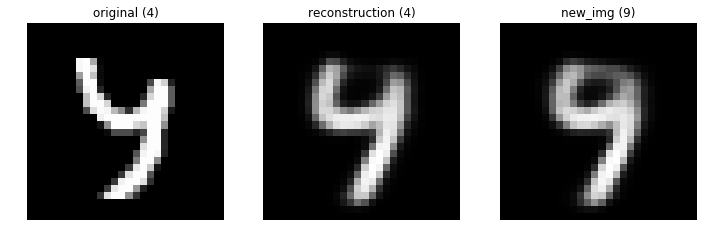

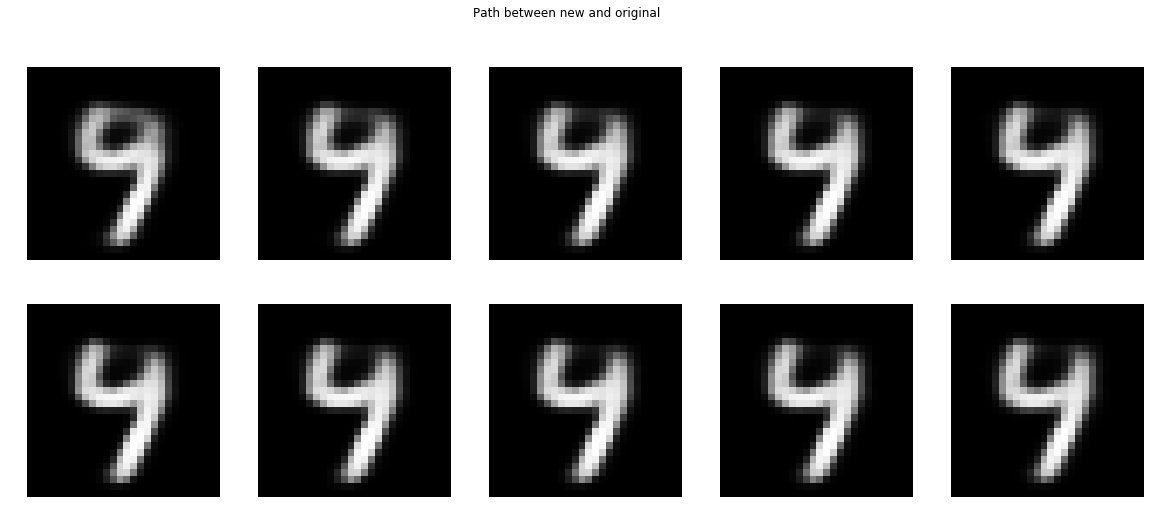

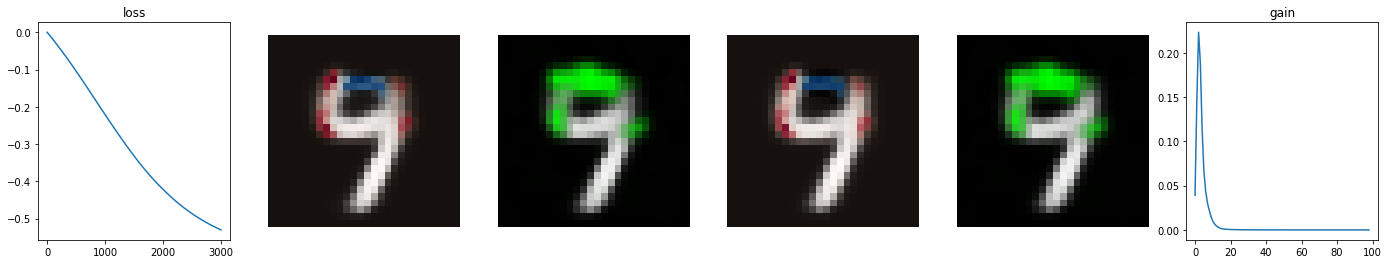

In [19]:
idx = 47068 # (4 to 9)
print(idx)

# Obtain image and its label from idx
original_img, real_label, real_class = dataset[idx]

original_label, new_label, path, path_emb, mask = explain(
    dataset, model, vae, device, original_img, real_label, 
    mask_iters=3000, mask_reg_alpha=1., mask_l1_ratio=1.
)

32239


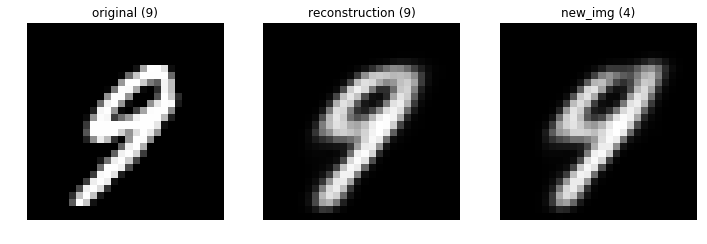

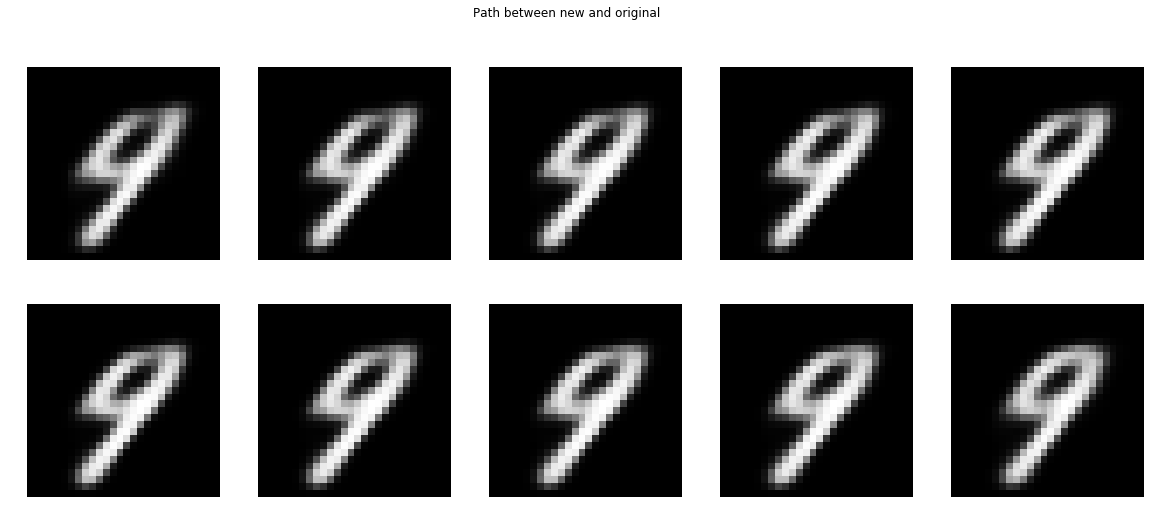

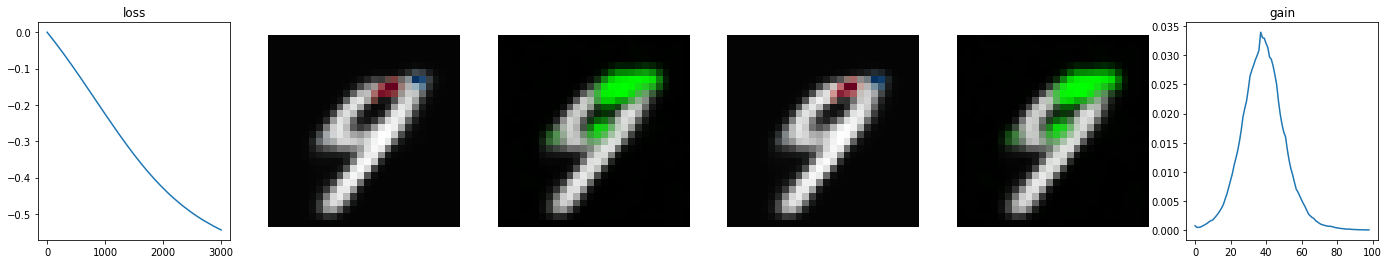

In [20]:
idx = 32239 # (9 to 4)
print(idx)

# Obtain image and its label from idx
original_img, real_label, real_class = dataset[idx]

original_label, new_label, path, path_emb, mask = explain(
    dataset, model, vae, device, original_img, real_label, 
    mask_iters=3000, mask_reg_alpha=1., mask_l1_ratio=1.
)

51725


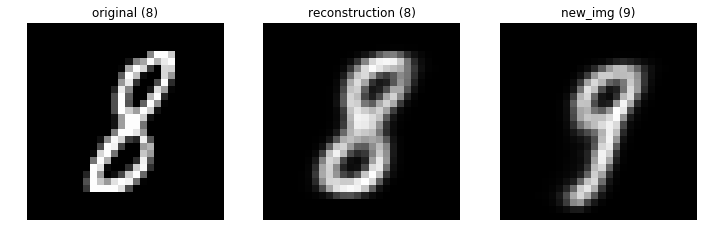

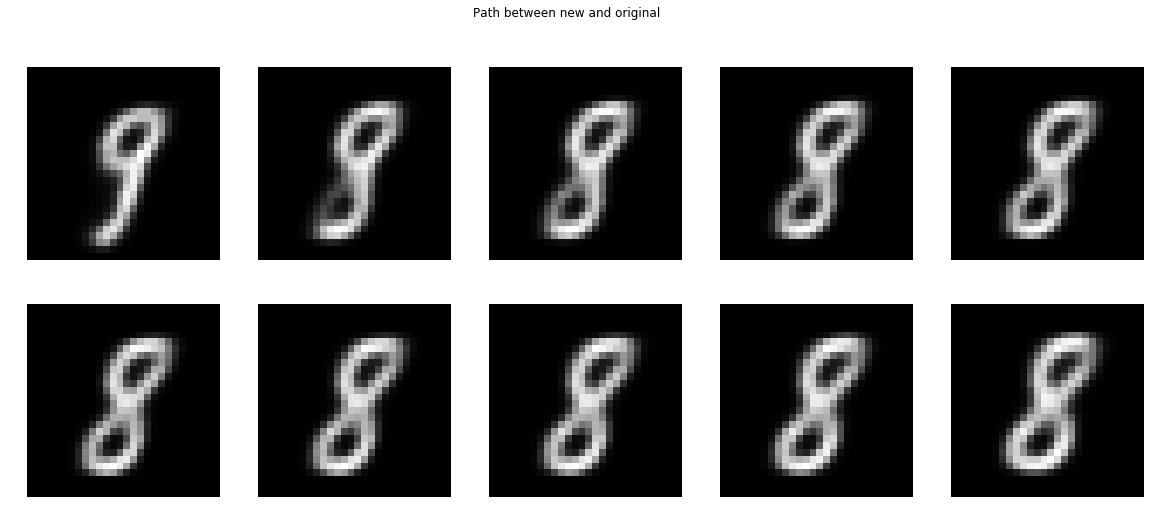

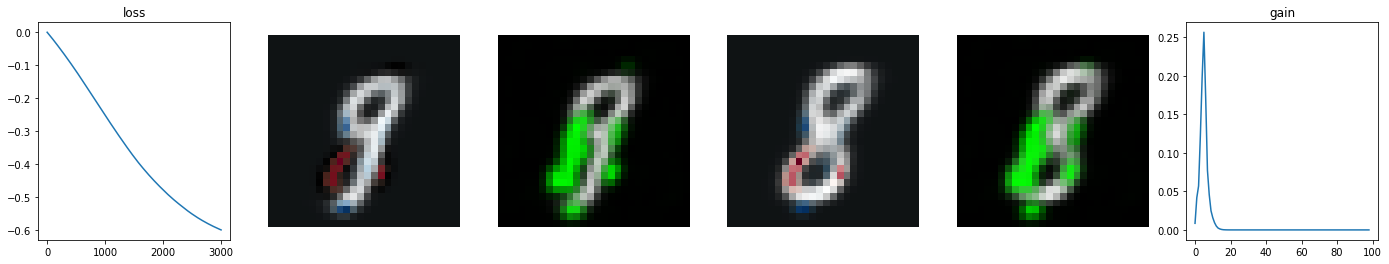

In [27]:
idx = np.random.choice(dataset.train)
print(idx)

# Obtain image and its label from idx
original_img, real_label, real_class = dataset[idx]

original_label, new_label, path, path_emb, mask = explain(
    dataset, model, vae, device, original_img, real_label, 
    mask_iters=3000, mask_reg_alpha=1., mask_l1_ratio=1.
)

24321


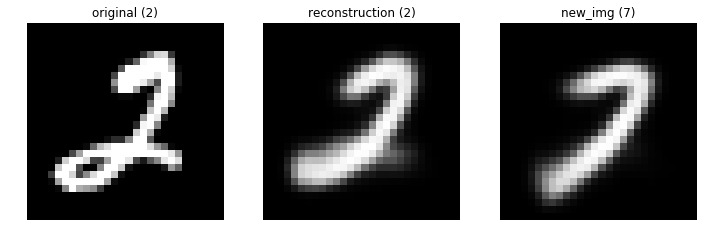

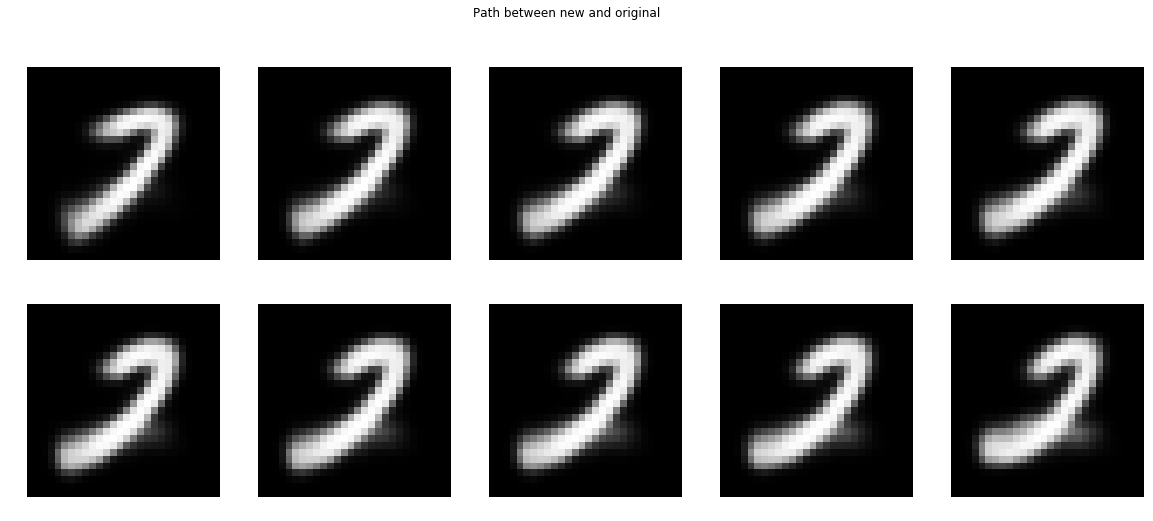

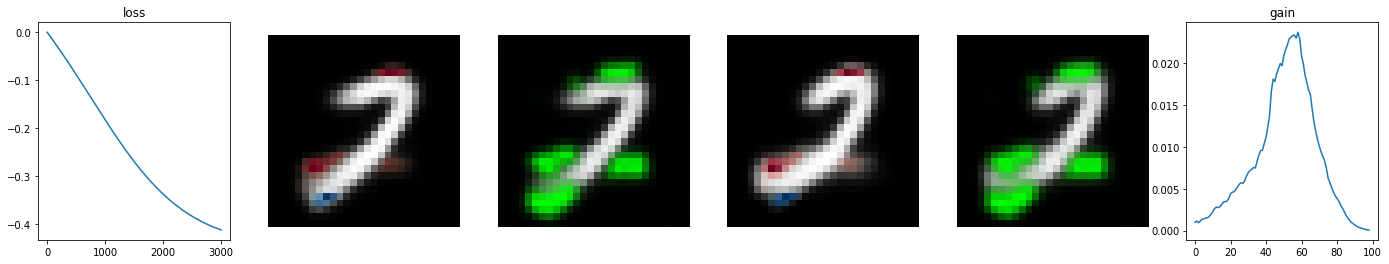

In [26]:
idx = np.random.choice(dataset.train)
print(idx)

# Obtain image and its label from idx
original_img, real_label, real_class = dataset[idx]

original_label, new_label, path, path_emb, mask = explain(
    dataset, model, vae, device, original_img, real_label, 
    mask_iters=3000, mask_reg_alpha=1., mask_l1_ratio=1.
)

23835


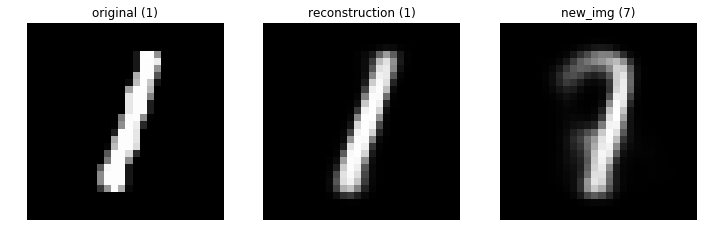

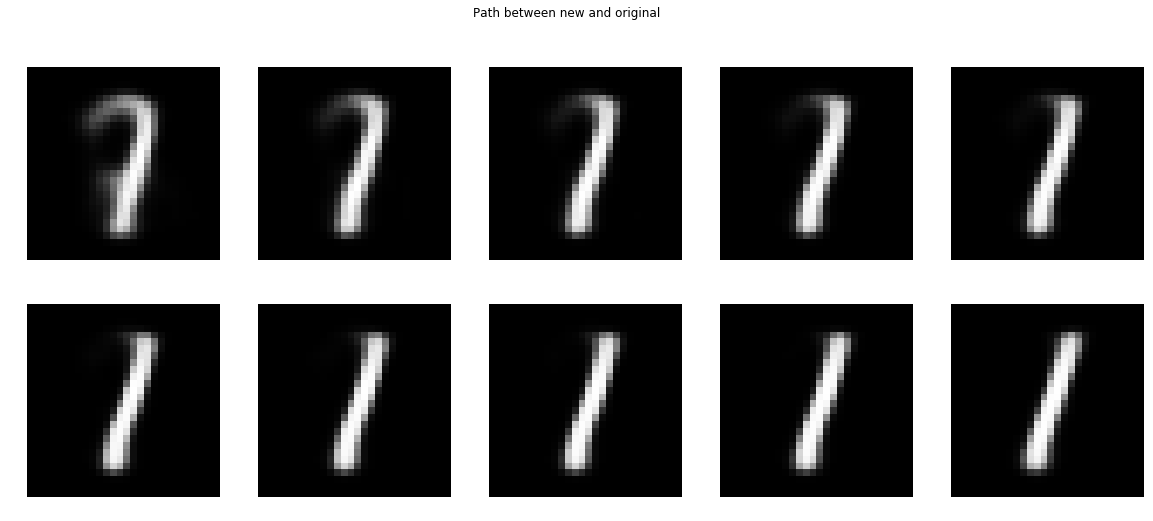

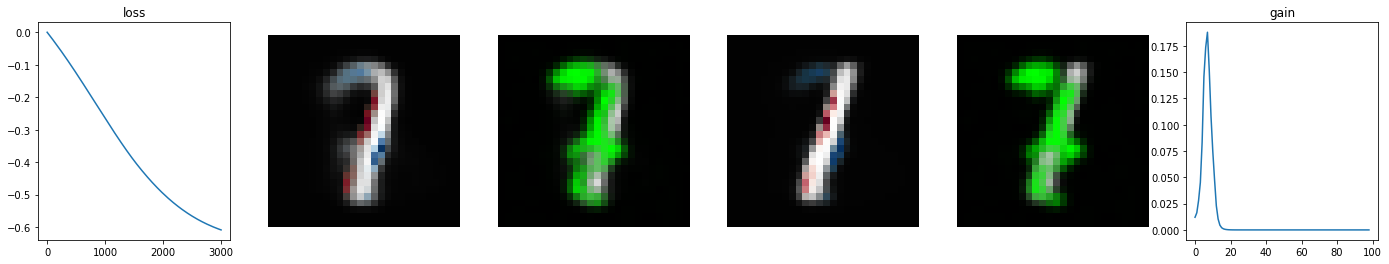

In [25]:
idx = np.random.choice(dataset.train)
print(idx)

# Obtain image and its label from idx
original_img, real_label, real_class = dataset[idx]

original_label, new_label, path, path_emb, mask = explain(
    dataset, model, vae, device, original_img, real_label, 
    mask_iters=3000, mask_reg_alpha=1., mask_l1_ratio=1.
)

# Experiments with wrongly predicted inputs

In [30]:
preds = []
labels = []

with torch.no_grad():
    for idx in dataset.test:
        X, y, _ = dataset[idx]
        X = X.to(device)
        preds.append(model(X.unsqueeze(0)).argmax(dim=1))
        labels.append(y)
        
preds = torch.cat(preds)
labels = torch.Tensor(labels).to(device)

err_idx = dataset.test[
    (labels.long() != preds).nonzero().squeeze().cpu().detach().numpy()
]

69729


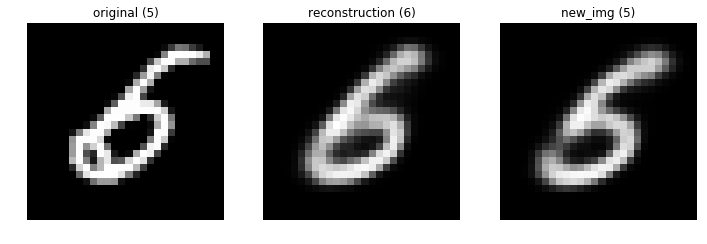

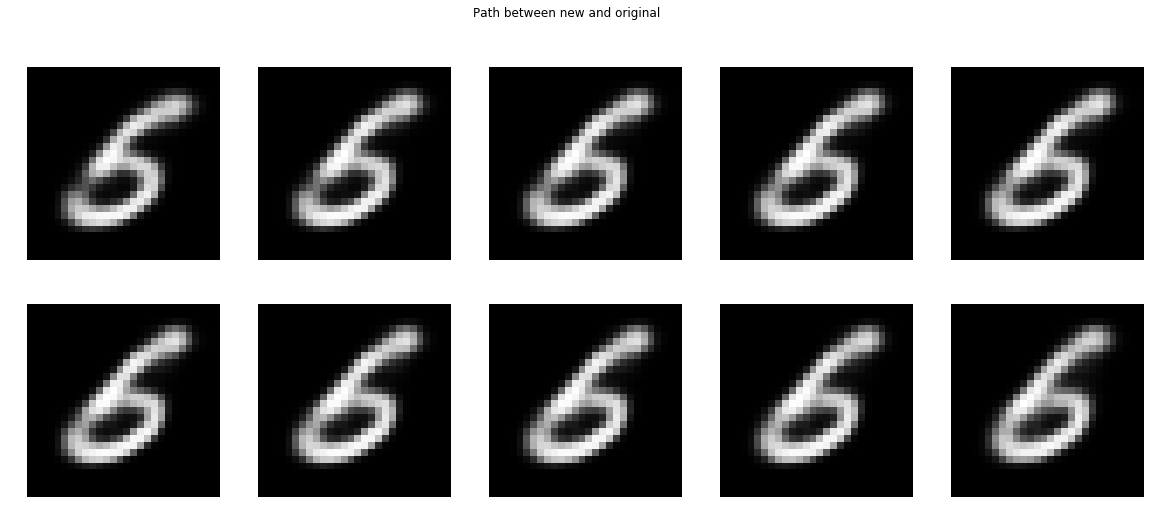

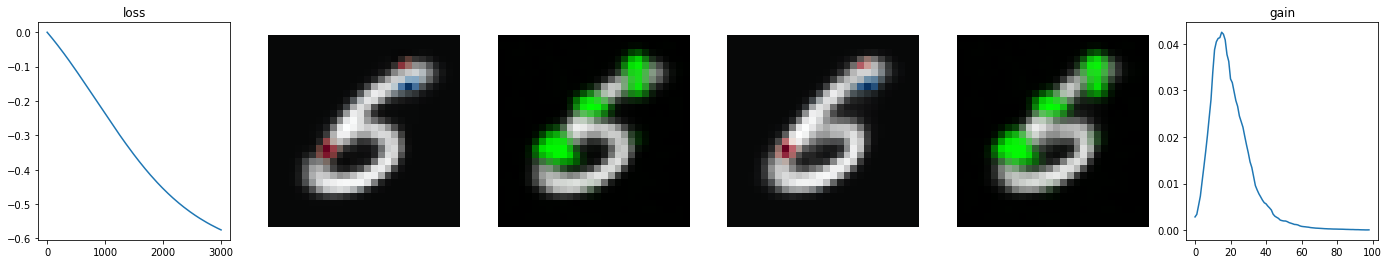

In [47]:
idx = np.random.choice(err_idx)
print(idx)

# Obtain image and its label from idx
original_img, real_label, real_class = dataset[idx]

original_label, new_label, path, path_emb, mask = explain(
    dataset, model, vae, device, original_img, real_label, 
    mask_iters=3000, mask_reg_alpha=1., mask_l1_ratio=1.
)

64176


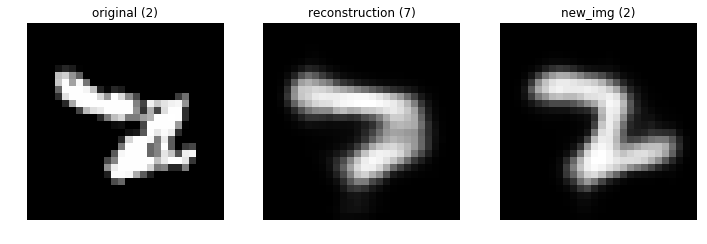

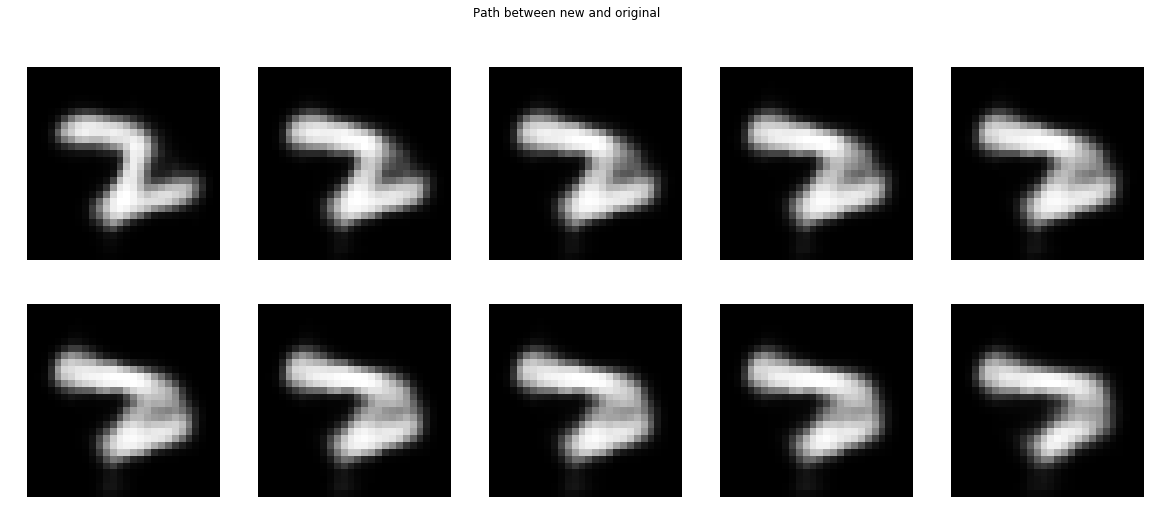

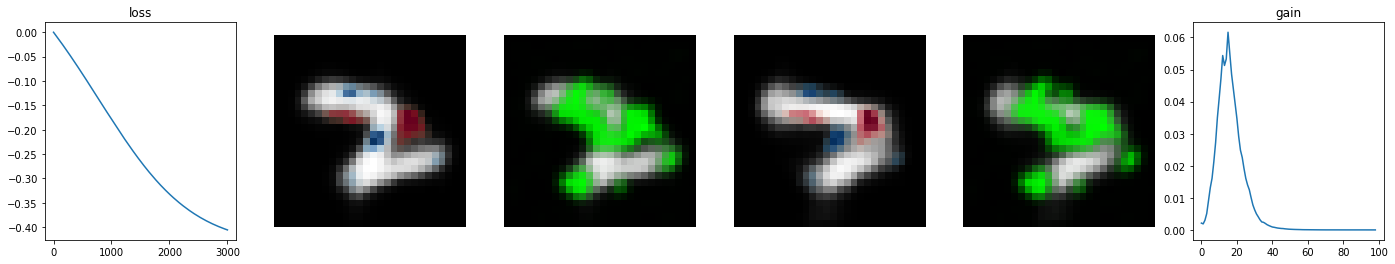

In [48]:
idx = np.random.choice(err_idx)
print(idx)

# Obtain image and its label from idx
original_img, real_label, real_class = dataset[idx]

original_label, new_label, path, path_emb, mask = explain(
    dataset, model, vae, device, original_img, real_label, 
    mask_iters=3000, mask_reg_alpha=1., mask_l1_ratio=1.
)

63422


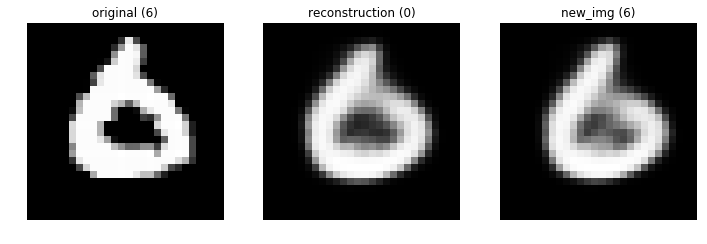

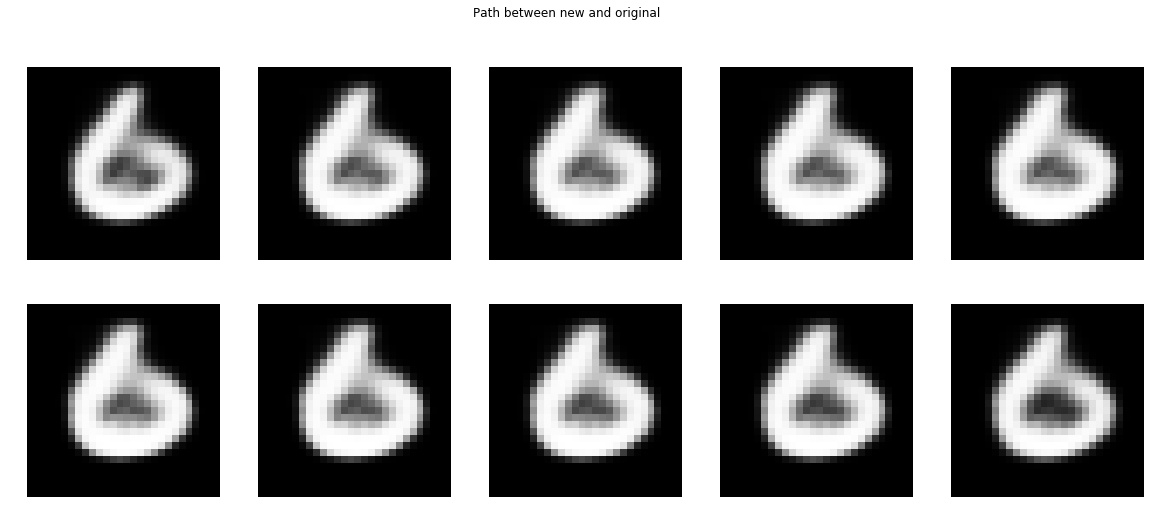

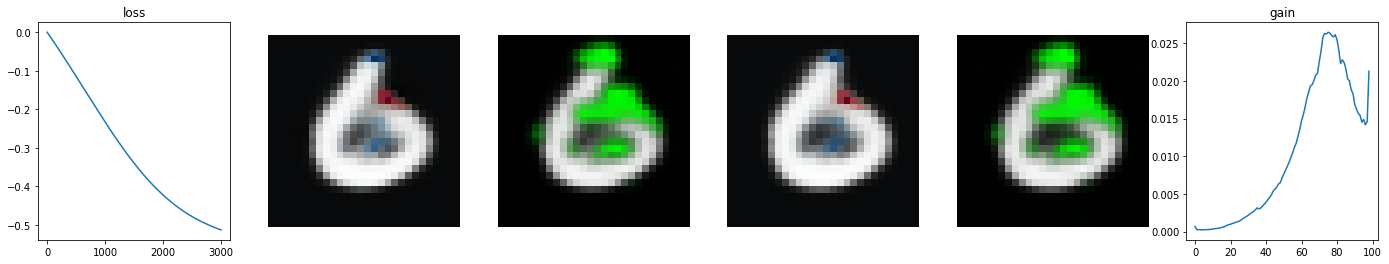

In [50]:
idx = np.random.choice(err_idx)
print(idx)

# Obtain image and its label from idx
original_img, real_label, real_class = dataset[idx]

original_label, new_label, path, path_emb, mask = explain(
    dataset, model, vae, device, original_img, real_label, 
    mask_iters=3000, mask_reg_alpha=1., mask_l1_ratio=1.
)

64838


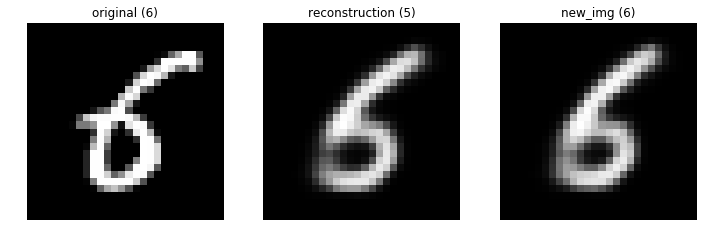

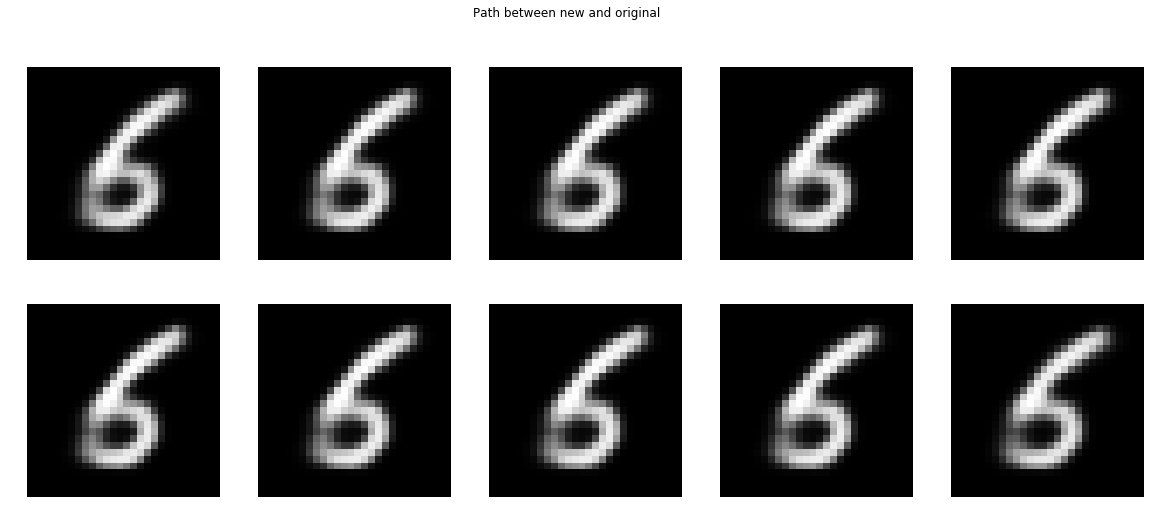

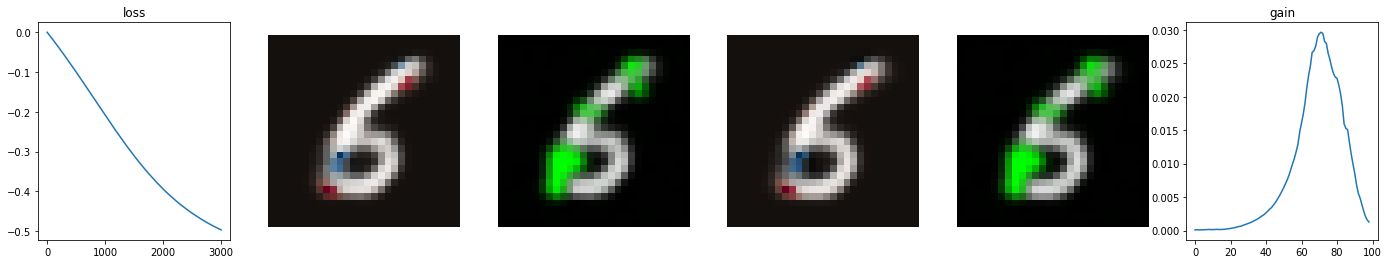

In [53]:
idx = np.random.choice(err_idx)
print(idx)

# Obtain image and its label from idx
original_img, real_label, real_class = dataset[idx]

original_label, new_label, path, path_emb, mask = explain(
    dataset, model, vae, device, original_img, real_label, 
    mask_iters=3000, mask_reg_alpha=1., mask_l1_ratio=1.
)

63853


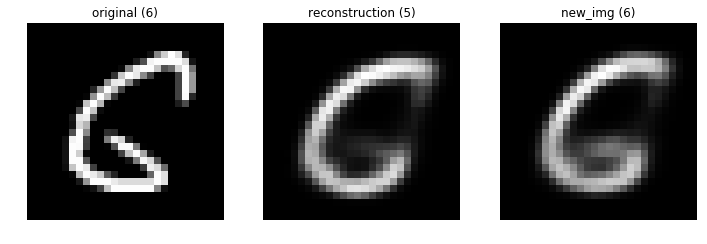

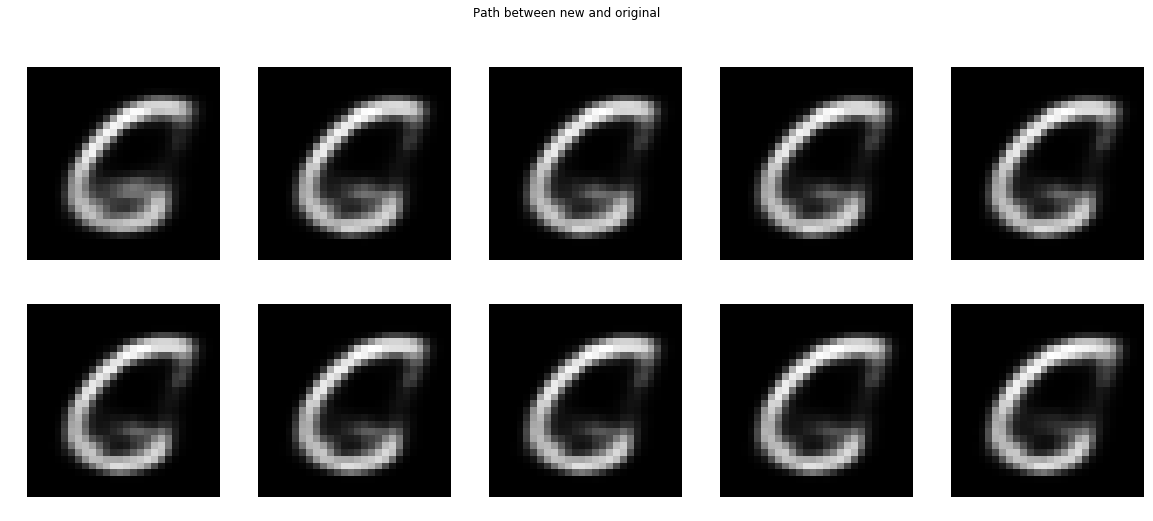

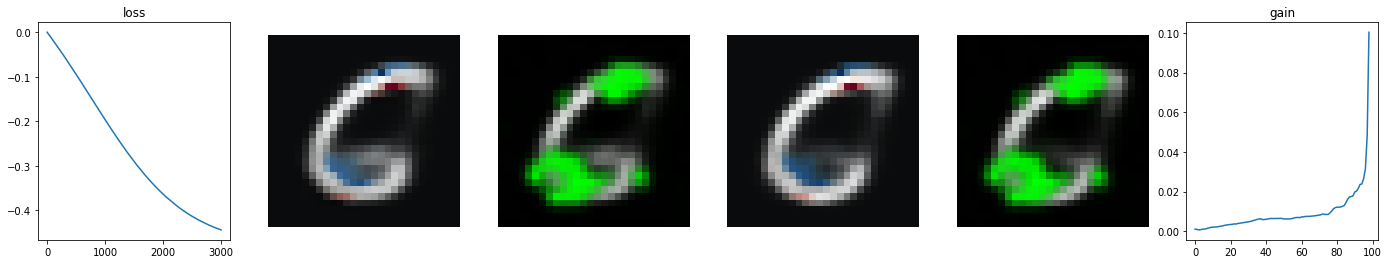

In [51]:
idx = np.random.choice(err_idx)
print(idx)

# Obtain image and its label from idx
original_img, real_label, real_class = dataset[idx]

original_label, new_label, path, path_emb, mask = explain(
    dataset, model, vae, device, original_img, real_label, 
    mask_iters=3000, mask_reg_alpha=1., mask_l1_ratio=1.
)